### **DRIVE**

In [0]:
#@title
from google.colab import drive
drive.mount('/content/drive')

### **IMPORTS**

In [0]:
#@title
!pip install pytorch_transformers
from pytorch_transformers import *
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import  tqdm_notebook
from sklearn.preprocessing import LabelEncoder as LE
import itertools

### **LOAD DATASET**

In [0]:
#@title
train=pd.read_csv('./drive/My Drive/datasets/Train.csv')
dev=pd.read_csv('./drive/My Drive/datasets/Dev.csv')
train_df=pd.concat([train,dev])

### **UTILITIES**

In [0]:
#@title
train_folder = "./drive/My Drive/datasets/train-articles" # check that the path to the datasets folder is correct, 
dev_folder = "./drive/My Drive/datasets/dev-articles"     # if not adjust these variables accordingly
train_labels_file = "./drive/My Drive/datasets/train-task2-TC.labels"
dev_template_labels_file = "./drive/My Drive/datasets/dev-task-TC-template.out"
task_TC_output_file = "BERT.txt"

def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels

#@title
# loading gold labels, articles ids and sentence ids from files *.task-TC.labels in the train labels folder 
ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(ref_span_starts), len(set(ref_articles_id))))

# reading data from the development set
dev_article_ids, dev_span_starts, dev_span_ends, dev_labels = read_predictions_from_file(dev_template_labels_file)

def pred_file(pred,x=True):
  if x:
    pred=le.inverse_transform(pred.argmax(axis=1)).tolist()
  ##### writing predictions to file
  with open(task_TC_output_file, "w") as fout:
      for article_id, prediction, span_start, span_end in zip(dev_article_ids, pred, dev_span_starts, dev_span_ends):
          fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
  print("Predictions written to file " + task_TC_output_file)
  from google.colab import files
  files.download('./{}.txt'.format(task_TC_output_file))

### **ENCODE SEQUENCES,OUTPUTS FOR BERT**

In [0]:
#@title
le=LE()
train_df.Sentence = train_df.Sentence.str.lower()
sentences = train_df.Sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
train.Target=le.fit_transform(train.Target)
labels = train.Target.values

In [0]:
#@title
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'the', 'next', 'transmission', 'could', 'be', 'more', 'pronounced', 'or', 'stronger', '[SEP]']
CPU times: user 1.6 s, sys: 4.38 ms, total: 1.6 s
Wall time: 2.51 s


### **PREPARE,SPLIT INPUT FOR BERT**

In [0]:
input_ids=[]
for i in tqdm_notebook(range(len(tokenized_texts))):
  input_ids.append(tokenizer.convert_tokens_to_ids(tokenized_texts[i]))

MAX_LEN = 100
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# SPLIT
train_inputs, validation_inputs, train_labels, = input_ids[:len(train)], input_ids[len(train):], labels
train_masks, validation_masks = attention_masks[:len(train)], attention_masks[len(train):]

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(train_labels[:len(dev)])
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### **TRAIN/TEST LOADERS**

In [0]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### **SHIFT MODEL TO GPU**

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=14)
model.to(device)

### **SET OPTIMIZER, LR Scheduler**

In [0]:
lr = 2e-6
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1

### In PyTorch-Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

### **TRAINING LOOP**

In [0]:
 def train(epochs=1,verbosity=50):
  total_step = len(train_dataloader)
  train_loss_set = []
  for epoch in tqdm_notebook(range(epochs)):
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      for i, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        tr_loss+=loss.item() 
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if i>0 (i % verbosity == verbosity-1):
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, tr_loss/50))
      train_loss_set.append(tr_loss)
  return train_loss_set

### **EVAL/META/VALIDATION**

In [0]:
def eval(mode='Proba'):
  pred_proba=[]
  with torch.no_grad():
    correct = 0
    total = 0
    pred=[]
    true=[]
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      predict_proba.append([outputs])
      prediction = torch.argmax(outputs[0],dim=1)
      pred+=[prediction.cpu()]
      total += b_labels.size(0)
      true += [b_labels.cpu()]
      correct+=(prediction==b_labels).sum().item()
  if mode=='Validation':
    print('Test Accuracy of the model on val data is: {} %'.format(100 * correct / total))
    return (100 * correct / total)
  elif mode=='Proba':
    return predict_proba
  else:
    pred = list(itertools.chain.from_iterable([i.tolist() for i in pred]))
    true = list(itertools.chain.from_iterable([i.tolist() for i in true]))
    return le.inverse_transform(pred)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        26
           1       0.42      0.39      0.40        59
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        22
           4       0.25      0.38      0.30        37
           5       0.61      0.66      0.63        97
           6       0.41      0.38      0.39       108
           7       0.58      0.60      0.59        50
           8       0.71      0.84      0.77       424
           9       0.72      0.81      0.76       201
          10       0.63      0.59      0.61       124
          11       0.50      0.17      0.25        30
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00        20

    accuracy                           0.63      1226
   macro avg       0.42      0.35      0.34      1226
weighted avg       0.59      0.63      0.60      1226



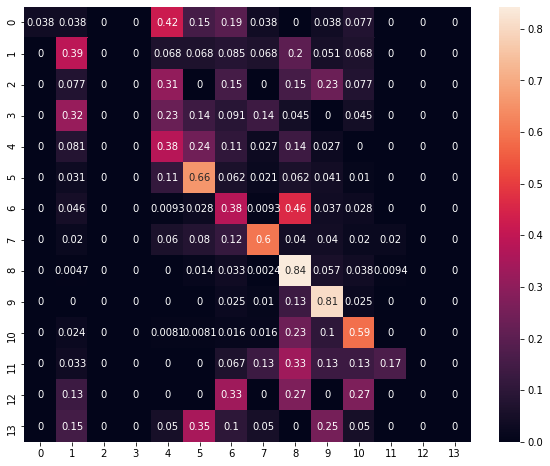

In [0]:
cm=confusion_matrix(true,pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,8))
sns.heatmap(cm,annot=True)

cf_rep=classification_report(true,pred)
print(cf_rep)

In [0]:

pred_file(pred,x=False)


Loaded 6129 annotations from 357 articles
Predictions written to file BERT.txt


array([1])